# Model 2: Anatomically accurate model of Amygdala

1. target behavioral data
    - conditioned fear response
    - extinction-induced reduction of fear response
    - renewal of fear response when the CS is presented in the original context
2. target activity data
    - LA pyramidal neurons (PN) become CS-responsive after conditioning
    - LA pyramidal neurons (PN) maintain CS-responsiveness after extinction
    - LA inhibitory neurons (PV and SOM) respond to the US, releasing inhibition of LA pyramidal cells
    - BLA fear neurons (excitatory) become CS-responsive after conditioning and lose CS-responsiveness after extinction
    - BLA extinction neurons (excitatory) become CS-responsive after extinction
    - BLA persistent neurons (excitatory) become CS-responsive after conditioning and maintain their activity after extinction
    - CeL "on" neurons (inhibitory) become more responsive to CS following conditioning
    - CeL "off" neurons (inhibitory) become less responsive to CS following conditioning


In [1]:
import numpy as np
import nengo
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from uniform_encoders import *

palette = sns.color_palette("colorblind")
sns.set_palette(palette)
sns.set(context='paper', style='white', font='CMU Serif')

In [2]:
class Inputs():
    def __init__(self, nCS=1, nCTX=2, dim_CS=3, dim_CTX=2, seed=0):
        self.rng = np.random.RandomState(seed=seed)
        self.sampler = ScatteredHypersphere(surface=True)
        self.dim_CS = dim_CS
        self.dim_CTX = dim_CTX
        self.nCS = nCS
        self.nCTX = nCTX
        self.CS = np.zeros((self.dim_CS))
        self.US = 0
        self.CTX = np.zeros((self.dim_CTX))
        self.CSs = self.sampler.sample(nCS, dim_CS, rng=self.rng)
        self.CTXs = self.sampler.sample(nCTX, dim_CTX, rng=self.rng)
        self.stop_learning = 0  # control signal to turn learning off
        self.applied_current = 0  # for experiments with external perturbation
        self.pause = False
    def get_CS(self, t):
        idx = int(t/2) % self.nCS
        applied = True if t%2>1 else False  # 1s of no input, 1s of CS input
        self.CS = self.CSs[idx] if applied and not self.pause else np.zeros((self.dim_CS))
        return self.CS
    def get_CTX(self, t):
        return self.CTX
    def get_US(self, t):
        idx = int(t/2) % self.nCS
        applied = True if t%2>1.5 else False # 1s of no input, 1s of US input 
        return self.US if applied else 0
    def get_stop_learning(self, t):
        return self.stop_learning
    def get_applied_current(self, t):
        return self.applied_current

In [3]:
dt = 0.001
nCond = 5
nExt = 10
seed = 0
nNeurons = 100
dim_CS = 3
dim_CTX = 5
nCS = 1
nCTX = 2
intercept_CS = 0
intercept_CTX = 0
intercept_LA_pyr = -0.5
lr = 1e-4  # learning_rate
rng = np.random.RandomState(seed=seed)
sampler = ScatteredHypersphere(surface=True)

inputs = Inputs(dim_CS=dim_CS, dim_CTX=dim_CTX, nCS=nCS, nCTX=nCTX, seed=seed)

encoders_LA_pyr = sampler.sample(2*nNeurons, 2, rng=rng)
intercepts_LA_pyr = nengo.dists.Uniform(intercept_LA_pyr, intercept_LA_pyr)
encoders_CS = sampler.sample(dim_CS*nNeurons, dim_CS, rng=rng)
encoders_CTX = sampler.sample(dim_CTX*nNeurons, dim_CTX, rng=rng)
intercepts_CS = nengo.dists.Uniform(intercept_CS, intercept_CS)
intercepts_CTX = nengo.dists.Uniform(intercept_CTX, intercept_CTX)
dInh = -3e0*np.ones((nNeurons, 1))

## Version 1
 - LA pyramidal and interneurons; functionally similar to model 1.1. LA neurons are divided into those response to US and those responsive to CS
 - PES learning updates connections weights from external_CS to LA_pyr, such that LA_pyr's CS response increases when the US is present alongside the CS
 - LA_inh receives CS and US information from external_CS and external_US via fixed connections, then gates learning in LA_pyr via inhibition

In [4]:
net = nengo.Network(seed=seed)
net.config[nengo.Connection].synapse = 0.01
net.config[nengo.Probe].synapse = 0.01

with net:
    # inputs and outputs
    CS = nengo.Node(lambda t, x: inputs.get_CS(t), size_in=2)
    US = nengo.Node(lambda t, x: inputs.get_US(t), size_in=2)
    CTX = nengo.Node(lambda t, x: inputs.get_CTX(t), size_in=2, size_out=dim_CTX)
    stop_learning = nengo.Node(lambda t, x: inputs.get_stop_learning(t), size_in=2)
    # external ensembles
    external_CS = nengo.Ensemble(dim_CS*nNeurons, dim_CS, intercepts=intercepts_CS, encoders=encoders_CS)
    external_US = nengo.Ensemble(nNeurons, 1)
    # amygdala ensembles
    LA_pyr = nengo.Ensemble(2*nNeurons, 2, encoders=encoders_LA_pyr, intercepts=intercepts_LA_pyr)  # [CS, US]
    LA_inh = nengo.Ensemble(2*nNeurons, 2)  # [CS, US]
    # error ensembles
    error_LA = nengo.Ensemble(nNeurons, 1)
    # external connections
    nengo.Connection(CS, external_CS, synapse=None)
    nengo.Connection(US, external_US, synapse=None)
    nengo.Connection(external_CS, LA_inh[0], function=lambda x: np.sum(np.square(x)))  # any CS present
    nengo.Connection(external_US, LA_inh[1])
    nengo.Connection(external_US, LA_pyr[1])
    # learned connections
    conditioning = nengo.Connection(external_CS, LA_pyr[0], function=lambda x: 0, learning_rule_type=nengo.PES(lr))
    # error connections
    nengo.Connection(LA_pyr, error_LA, function=lambda x: x[1]-x[0])  # US - CS response
    # error gating
    nengo.Connection(LA_inh, error_LA.neurons, function=lambda x: x[0]-x[1], transform=dInh)  # inhibit if only CS present
    # error updating
    nengo.Connection(error_LA, conditioning.learning_rule, transform=-1)
    # prevent learning during testing
    nengo.Connection(stop_learning, error_LA.neurons, transform=dInh)
    # probes
    pCS = nengo.Probe(CS, synapse=None)
    pUS = nengo.Probe(US, synapse=None)
    pCTX = nengo.Probe(CTX, synapse=None)
    pLA_pyr_spikes = nengo.Probe(LA_pyr.neurons)
    pLA_inh_spikes = nengo.Probe(LA_inh.neurons)
    pLA_pyr = nengo.Probe(LA_pyr)
    pLA_inh = nengo.Probe(LA_inh)
    pError_LA = nengo.Probe(error_LA)

In [5]:
sim = nengo.Simulator(net, dt=dt, progress_bar=False)
with sim:
    print("control")
    inputs.CTX = inputs.CTXs[0]
    sim.run(2)
    print("conditioning")
    inputs.CTX = inputs.CTXs[0]
    inputs.US = 1
    for p in range(nCond):
        sim.run(2)
    print("pause")
    inputs.pause = True
    inputs.CTX = np.zeros((dim_CTX))
    inputs.US = 0
    sim.run(4)
    inputs.pause = False
    print("extinction")
    inputs.CTX = inputs.CTXs[1]
    inputs.US = 0
    for p in range(nExt):
        sim.run(2)

control
conditioning
pause
extinction


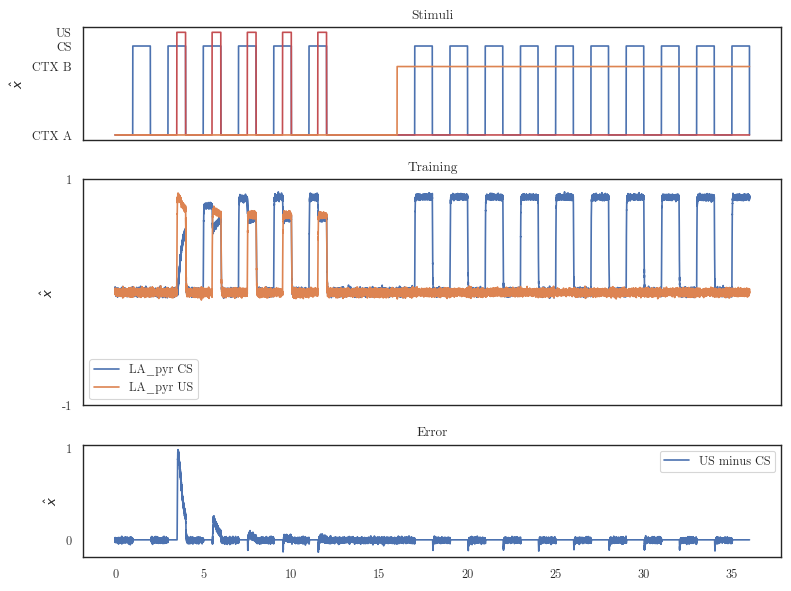

In [6]:
ctxA_idx = np.where(sim.data[pCTX]==inputs.CTXs[0])[0]
ctxB_idx = np.where(sim.data[pCTX]==inputs.CTXs[1])[0]
ctx_signal = np.zeros((sim.trange().shape[0]))
ctx_signal[ctxB_idx] = 1

fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=((8,6)), gridspec_kw={'height_ratios': [2,4,2]})
axes[0].plot(sim.trange(), 1.3*np.linalg.norm(sim.data[pCS], ord=2, axis=1), label="CS present")
axes[0].plot(sim.trange(), 1.5*sim.data[pUS], label="US", c='r')
axes[0].plot(sim.trange(), ctx_signal, label="CTX")
axes[0].set(yticks=((0,1,1.3,1.5)), yticklabels=(("CTX A","CTX B","CS","US")), ylabel=r"$\hat{x}$", title="Stimuli")
axes[1].plot(sim.trange(), sim.data[pLA_pyr][:,0], label="LA_pyr CS")
axes[1].plot(sim.trange(), sim.data[pLA_pyr][:,1], label="LA_pyr US")
axes[1].legend()
axes[1].set(yticks=((-1, 1)), yticklabels=((-1,1)), ylabel=r"$\hat{x}$", title="Training")
axes[2].plot(sim.trange(), sim.data[pError_LA], label="US minus CS")
axes[2].legend()
axes[2].set(ylabel=r"$\hat{x}$", title="Error", yticks=((0,1)))
plt.tight_layout()

20.5% of LA neurons become more CS responsive, 38.0% become less CS responsive


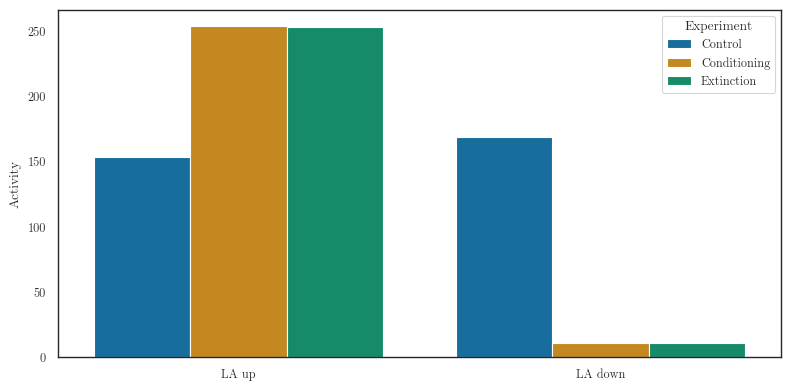

In [8]:
T1a = int(1/dt)
T1b = int(2/dt)
T2a = int((2+2*nCond-1)/dt)
T2b = int((2+2*nCond-0.5)/dt)
T3a = int((2+2*nCond+4+2*nExt-1)/dt)
T3b = int((2+2*nCond+4+2*nExt-0.5)/dt)
data_activity = pd.DataFrame(columns=["seed", "Type", "Activity", "Experiment"])
            
aControl_LA_pyr = sim.data[pLA_pyr_spikes][T1a: T1b]
aConditioning_LA_pyr = sim.data[pLA_pyr_spikes][T2a: T2b]
aExtinction_LA_pyr = sim.data[pLA_pyr_spikes][T3a: T3b]
LA_pyr_up = np.where(np.mean(aConditioning_LA_pyr, axis=0) > 1.5*np.mean(aControl_LA_pyr, axis=0))[0]
LA_pyr_down = np.where(np.mean(aConditioning_LA_pyr, axis=0) < 0.5*np.mean(aControl_LA_pyr, axis=0))[0]

data_activity = data_activity.append({"seed": seed, "Type": "LA up", "Activity": np.mean(aControl_LA_pyr[:,LA_pyr_up]), "Experiment": "Control"}, ignore_index=True)
data_activity = data_activity.append({"seed": seed, "Type": "LA up", "Activity": np.mean(aConditioning_LA_pyr[:,LA_pyr_up]), "Experiment": "Conditioning"}, ignore_index=True)
data_activity = data_activity.append({"seed": seed, "Type": "LA up", "Activity": np.mean(aExtinction_LA_pyr[:,LA_pyr_up]), "Experiment": "Extinction"}, ignore_index=True)
data_activity = data_activity.append({"seed": seed, "Type": "LA down", "Activity": np.mean(aControl_LA_pyr[:,LA_pyr_down]), "Experiment": "Control"}, ignore_index=True)
data_activity = data_activity.append({"seed": seed, "Type": "LA down", "Activity": np.mean(aConditioning_LA_pyr[:,LA_pyr_down]), "Experiment": "Conditioning"}, ignore_index=True)
data_activity = data_activity.append({"seed": seed, "Type": "LA down", "Activity": np.mean(aExtinction_LA_pyr[:,LA_pyr_down]), "Experiment": "Extinction"}, ignore_index=True)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=((8,4)))
sns.barplot(data=data_activity, x='Type', y="Activity", hue="Experiment", palette=palette, ax=ax)
ax.set(xlabel=None)
plt.tight_layout()

percent_up = len(LA_pyr_up)/(2*nNeurons)*100
percent_down = len(LA_pyr_down)/(2*nNeurons)*100
print(f"{percent_up}% of LA neurons become more CS responsive, {percent_down}% become less CS responsive")

## Version 2
 - adds CeL and CeM. These populations convey LA_pyr output (learned CS responses) to the amygdala's output, causing fear response
 - PES learning updates connections weights from LA_pyr to CeL, such that CeL's CS response increases when the US is present alongside the CS
 - A constant bias is sent to CeM and to one dimension of CeL. This causes CeM, and some neurons in CeL, to fire without external input. These spontaneously active CeL cells inhibit CeM, such that, with no external input, CeM is quiet, and no fear response occurs
 - When CeL becomes conditioned to respond to CS via learned projections from LA, CS-responsive CeL neurons compete with spontaneously active CeL neurons to activate CeM, causing fear response. We realize this competition via a functional connection from CeL (CS-response minus bias); biologically, this likely happens through lateral inhibition in CeL and disinhibition of CeM.

In [45]:
net = nengo.Network(seed=seed)
net.config[nengo.Connection].synapse = 0.01
net.config[nengo.Probe].synapse = 0.01

intercepts_pos = nengo.dists.Uniform(0,1)
encoders_pos = nengo.dists.Choice([[1]])

with net:
    # inputs and outputs
    CS = nengo.Node(lambda t, x: inputs.get_CS(t), size_in=2)
    US = nengo.Node(lambda t, x: inputs.get_US(t), size_in=2)
    CTX = nengo.Node(lambda t, x: inputs.get_CTX(t), size_in=2, size_out=dim_CTX)
    bias = nengo.Node(lambda t: 1.0)
    # external ensembles
    external_CS = nengo.Ensemble(dim_CS*nNeurons, dim_CS, intercepts=intercepts_CS, encoders=encoders_CS)
    external_US = nengo.Ensemble(nNeurons, 1)
    # amygdala ensembles
    LA_pyr = nengo.Ensemble(2*nNeurons, 2, encoders=encoders_LA_pyr, intercepts=intercepts_LA_pyr)  # [CS, US]
    LA_inh = nengo.Ensemble(2*nNeurons, 2)  # [CS, US]
    CeL_on = nengo.Ensemble(nNeurons, 1, intercepts=intercepts_pos, encoders=encoders_pos)  # [CS]
    CeL_off = nengo.Ensemble(nNeurons, 1, intercepts=intercepts_pos, encoders=encoders_pos)  # [bias-CS]
    CeM = nengo.Ensemble(nNeurons, 1, intercepts=intercepts_pos, encoders=encoders_pos)
    # error ensembles
    error_LA = nengo.Ensemble(nNeurons, 1)
    error_CeL = nengo.Ensemble(nNeurons, 1)
    # external connections
    nengo.Connection(CS, external_CS, synapse=None)
    nengo.Connection(US, external_US, synapse=None)
    nengo.Connection(external_CS, LA_inh[0], function=lambda x: np.sum(np.square(x)))  # any CS present
    nengo.Connection(external_US, LA_inh[1])
    nengo.Connection(external_US, LA_pyr[1])
    nengo.Connection(bias, CeL_off)
    nengo.Connection(bias, CeM)
    # internal connections
    nengo.Connection(CeL_on, CeL_off, transform=-1)
    nengo.Connection(CeL_off, CeM, transform=-1)
    # learned connections
    conditioning = nengo.Connection(external_CS, LA_pyr[0], function=lambda x: 0, learning_rule_type=nengo.PES(lr))
    transmission = nengo.Connection(LA_pyr[0], CeL_on, function=lambda x: 0, learning_rule_type=nengo.PES(lr))
    # error connections
    nengo.Connection(LA_pyr, error_LA, function=lambda x: x[1]-x[0])  # US - CS response
    nengo.Connection(LA_pyr[0], error_CeL, transform=+1)  # LA_pyr CS response
    nengo.Connection(CeL_on, error_CeL, transform=-1)  # -CeL_on CS response
    # error gating
    nengo.Connection(LA_inh, error_LA.neurons, function=lambda x: x[0]-x[1], transform=dInh)  # inhibit if only CS present
    # error updating
    nengo.Connection(error_LA, conditioning.learning_rule, transform=-1)
    nengo.Connection(error_CeL, transmission.learning_rule, transform=-1)
    # probes
    pCS = nengo.Probe(CS, synapse=None)
    pUS = nengo.Probe(US, synapse=None)
    pCTX = nengo.Probe(CTX, synapse=None)
    pLA_pyr_spikes = nengo.Probe(LA_pyr.neurons)
    pLA_inh_spikes = nengo.Probe(LA_inh.neurons)
    pCeL_on_spikes = nengo.Probe(CeL_on.neurons)
    pCeL_off_spikes = nengo.Probe(CeL_off.neurons)
    pCeM_spikes = nengo.Probe(CeM.neurons)
    pLA_pyr = nengo.Probe(LA_pyr)
    pLA_inh = nengo.Probe(LA_inh)
    pCeL_on = nengo.Probe(CeL_on)
    pCeL_off = nengo.Probe(CeL_off)
    pCeM = nengo.Probe(CeM)
    pError_LA = nengo.Probe(error_LA)
    pError_CeL = nengo.Probe(error_CeL)

In [46]:
sim = nengo.Simulator(net, dt=dt, progress_bar=False)
with sim:
    print("control")
    inputs.CTX = inputs.CTXs[0]
    sim.run(2)
    print("conditioning")
    inputs.CTX = inputs.CTXs[0]
    inputs.US = 1
    for p in range(nCond):
        sim.run(2)
    print("pause")
    inputs.pause = True
    inputs.CTX = np.zeros((dim_CTX))
    inputs.US = 0
    sim.run(4)
    inputs.pause = False
    print("extinction")
    inputs.CTX = inputs.CTXs[1]
    inputs.US = 0
    for p in range(nExt):
        sim.run(2)

control
conditioning
pause
extinction


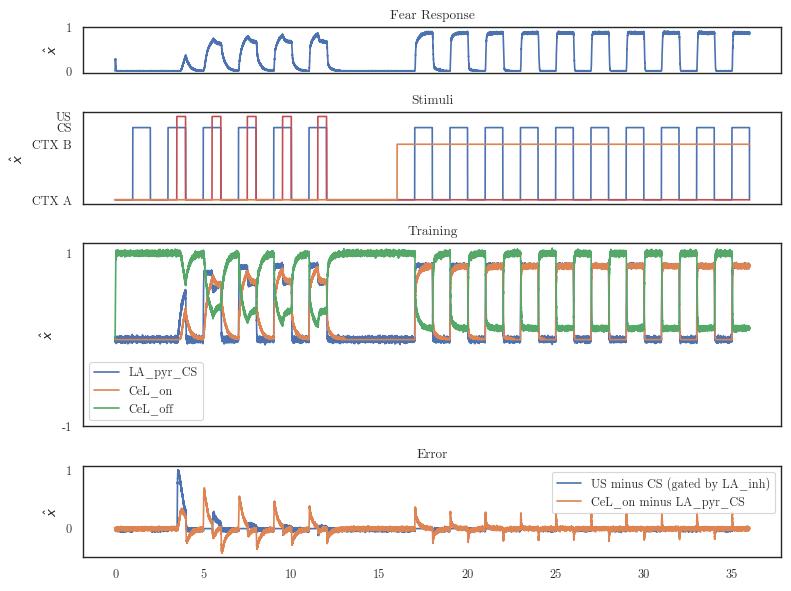

In [47]:
ctxA_idx = np.where(sim.data[pCTX]==inputs.CTXs[0])[0]
ctxB_idx = np.where(sim.data[pCTX]==inputs.CTXs[1])[0]
ctx_signal = np.zeros((sim.trange().shape[0]))
ctx_signal[ctxB_idx] = 1

fig, axes = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=((8,6)), gridspec_kw={'height_ratios': [1,2,4,2]})
axes[0].plot(sim.trange(), sim.data[pCeM])
axes[0].set(ylabel=r"$\hat{x}$", title="Fear Response", yticks=((0,1)))
axes[1].plot(sim.trange(), 1.3*np.linalg.norm(sim.data[pCS], ord=2, axis=1), label="CS present")
axes[1].plot(sim.trange(), 1.5*sim.data[pUS], label="US", c='r')
axes[1].plot(sim.trange(), ctx_signal, label="CTX")
axes[1].set(yticks=((0,1,1.3,1.5)), yticklabels=(("CTX A","CTX B","CS","US")), ylabel=r"$\hat{x}$", title="Stimuli")
axes[2].plot(sim.trange(), sim.data[pLA_pyr][:,0], label="LA_pyr_CS")
axes[2].plot(sim.trange(), sim.data[pCeL_on], label="CeL_on")
axes[2].plot(sim.trange(), sim.data[pCeL_off], label="CeL_off")
axes[2].legend()
axes[2].set(yticks=((-1, 1)), yticklabels=((-1,1)), ylabel=r"$\hat{x}$", title="Training")
axes[3].plot(sim.trange(), sim.data[pError_LA], label="US minus CS (gated by LA_inh)")
axes[3].plot(sim.trange(), sim.data[pError_CeL], label="CeL_on minus LA_pyr_CS")
axes[3].legend()
axes[3].set(ylabel=r"$\hat{x}$", title="Error", yticks=((0,1)))
plt.tight_layout()

## Version 3
 - return to version 1, then add a BLA, which includes BLA_pyramidal and BLA_interneurons. Functionally similar to model1.3
 - BLA_pyr and BLA_inh receive [CS, US] information from LA_pyr
 - BLA_pyr receives an external connection conveying CTX information. Use PES learning on this connection such that two trends occur (mediated by separate error populations):
    - when CTX is present alongside US, learn a fear association between the two (error = BLA_US - BLA_CTX). This error should be inhibited unless the US is present
    - when CTX is present alongside BLA_CS response, but no US is present, learn a safety association between CTX and CS (error = BLA_CS - BLA_CTX) (technically CS + CTX, because BLA_CTX representation becomes negative)
 - BLA_inh gates the BLA_error populations appropriately, given CS and US information

In [11]:
lr = 3e-5

net = nengo.Network(seed=seed)
net.config[nengo.Connection].synapse = 0.03
net.config[nengo.Probe].synapse = 0.03
intercepts_pos = nengo.dists.Uniform(0,1)
encoders_pos = nengo.dists.Choice([[1]])
intercept_BLA_pyr = 0.0
encoders_BLA_pyr = sampler.sample(4*nNeurons, 4, rng=rng)
intercepts_BLA_pyr = nengo.dists.Uniform(intercept_BLA_pyr, intercept_BLA_pyr)
    
with net:
    # inputs and outputs
    CS = nengo.Node(lambda t, x: inputs.get_CS(t), size_in=2)
    US = nengo.Node(lambda t, x: inputs.get_US(t), size_in=2)
    CTX = nengo.Node(lambda t, x: inputs.get_CTX(t), size_in=2, size_out=dim_CTX)
    bias = nengo.Node(lambda t: 0.5)
    # external ensembles
    external_CS = nengo.Ensemble(dim_CS*nNeurons, dim_CS, intercepts=intercepts_CS, encoders=encoders_CS)
    external_US = nengo.Ensemble(nNeurons, 1)
    external_CTX = nengo.Ensemble(dim_CTX*nNeurons, dim_CTX, intercepts=intercepts_CTX, encoders=encoders_CTX)
    # amygdala ensembles
    LA_pyr = nengo.Ensemble(2*nNeurons, 2, encoders=encoders_LA_pyr, intercepts=intercepts_LA_pyr)  # [CS, US]
    LA_inh = nengo.Ensemble(2*nNeurons, 2)  # [CS, US]
    CeL_on = nengo.Ensemble(nNeurons, 1, intercepts=intercepts_pos, encoders=encoders_pos)  # [CS]
    CeL_off = nengo.Ensemble(nNeurons, 1, intercepts=intercepts_pos, encoders=encoders_pos)  # [bias-CS]
    CeM = nengo.Ensemble(nNeurons, 1, intercepts=intercepts_pos, encoders=encoders_pos)
    BLA_pyr = nengo.Ensemble(4*nNeurons, 4, radius=4, encoders=encoders_BLA_pyr, intercepts=intercepts_BLA_pyr)  # [CS, US, CTX]
    BLA_inh = nengo.Ensemble(2*nNeurons, 2, radius=2)  # [CS, US]
    # error ensembles
    error_LA = nengo.Ensemble(nNeurons, 1)
    error_CeL = nengo.Ensemble(nNeurons, 1)
    error_BLA_safe = nengo.Ensemble(nNeurons, 1)
    error_BLA_fear = nengo.Ensemble(nNeurons, 1)
    # external connections
    nengo.Connection(CS, external_CS, synapse=None)
    nengo.Connection(US, external_US, synapse=None)
    nengo.Connection(external_CS, LA_inh[0], function=lambda x: np.sum(np.square(x)))  # any CS present
    nengo.Connection(external_US, LA_inh[1])
    nengo.Connection(external_US, LA_pyr[1])
    nengo.Connection(bias, CeL_off, transform=1)
    nengo.Connection(bias, CeM)
    nengo.Connection(CTX, external_CTX, synapse=None)
    # internal connections
    nengo.Connection(CeL_on, CeL_off, transform=-1)
    nengo.Connection(CeL_off, CeM, transform=-1)
    nengo.Connection(LA_pyr, BLA_pyr[:2])  # communicate [CS, US]
    nengo.Connection(BLA_pyr[:2], BLA_inh)  # communicate [CS,US]
    nengo.Connection(BLA_pyr[0], BLA_pyr[3], transform=0.25)  # CS response added to total fear response
    nengo.Connection(BLA_pyr[2], BLA_pyr[3], transform=0.75)  # CTX response added to total fear response
    nengo.Connection(BLA_pyr[3], CeM)  # communicate total fear response to CeM
    # learned connections
    conditioning = nengo.Connection(external_CS, LA_pyr[0], function=lambda x: 0, learning_rule_type=nengo.PES(lr))
    transmission = nengo.Connection(LA_pyr[0], CeL_on, function=lambda x: 0, learning_rule_type=nengo.PES(lr))
    extinction = nengo.Connection(external_CTX, BLA_pyr[2], function=lambda x: 0, learning_rule_type=nengo.PES(0.3*lr))
    # error connections
    nengo.Connection(LA_pyr, error_LA, function=lambda x: x[1]-x[0])  # US - CS response
    nengo.Connection(LA_pyr[0], error_CeL, transform=+1)  # LA_pyr CS response
    nengo.Connection(CeL_on, error_CeL, transform=-1)  # -CeL_on CS response
    nengo.Connection(BLA_pyr, error_BLA_safe, function=lambda x: x[0]+x[2])  # CS response + (-) CTX response
    nengo.Connection(BLA_pyr, error_BLA_fear, function=lambda x: x[1]-x[2])   # US response - CTX response
    # error gating
    nengo.Connection(LA_inh, error_LA.neurons, function=lambda x: x[0]-x[1], transform=dInh)  # inhibit if only CS present
    nengo.Connection(BLA_inh, error_BLA_safe.neurons, function=lambda x: 1-x[0], transform=dInh)  # inhibit by default; release if CS
    nengo.Connection(BLA_inh, error_BLA_safe.neurons, function=lambda x: x[1], transform=10*dInh, synapse=1.0)  # inhibit if recent US
    nengo.Connection(BLA_inh, error_BLA_fear.neurons, function=lambda x: 1-1.2*x[1], transform=0.5*dInh)  # slow learning unless US

    # error updating
    nengo.Connection(error_LA, conditioning.learning_rule, transform=-1)
    nengo.Connection(error_CeL, transmission.learning_rule, transform=-1)
    nengo.Connection(error_BLA_safe, extinction.learning_rule, transform=1)
    nengo.Connection(error_BLA_fear, extinction.learning_rule, transform=-1)

    # probes
    pCS = nengo.Probe(CS, synapse=None)
    pUS = nengo.Probe(US, synapse=None)
    pCTX = nengo.Probe(CTX, synapse=None)
    pLA_pyr_spikes = nengo.Probe(LA_pyr.neurons)
    pLA_inh_spikes = nengo.Probe(LA_inh.neurons)
    pCeL_on_spikes = nengo.Probe(CeL_on.neurons)
    pCeL_off_spikes = nengo.Probe(CeL_off.neurons)
    pCeM_spikes = nengo.Probe(CeM.neurons)
    pBLA_pyr_spikes = nengo.Probe(BLA_pyr.neurons)
    pBLA_inh_spikes = nengo.Probe(BLA_inh.neurons)
    pBLA_pyr = nengo.Probe(BLA_pyr)
    pBLA_inh = nengo.Probe(BLA_inh)
    pLA_pyr = nengo.Probe(LA_pyr)
    pLA_inh = nengo.Probe(LA_inh)
    pCeL_on = nengo.Probe(CeL_on)
    pCeL_off = nengo.Probe(CeL_off)
    pCeM = nengo.Probe(CeM)
    pError_LA = nengo.Probe(error_LA)
    pError_CeL = nengo.Probe(error_CeL)
    pBLA_pyr = nengo.Probe(BLA_pyr)
    pBLA_inh = nengo.Probe(BLA_inh)
    pBLA_inh_US = nengo.Probe(BLA_inh[1], synapse=1.0)
    pError_BLA_safe = nengo.Probe(error_BLA_safe)
    pError_BLA_fear = nengo.Probe(error_BLA_fear)    

In [12]:
nExt = 10
sim = nengo.Simulator(net, dt=dt, progress_bar=False)
with sim:
    print("control")
    inputs.CTX = inputs.CTXs[0]
    sim.run(2)
    print("conditioning")
    inputs.CTX = inputs.CTXs[0]
    inputs.US = 1
    for p in range(nCond):
        sim.run(2)
    print("pause")
    inputs.pause = True
    inputs.CTX = np.zeros((dim_CTX))
    inputs.US = 0
    sim.run(4)
    inputs.pause = False
    print("extinction")
    inputs.CTX = inputs.CTXs[1]
    inputs.US = 0
    for p in range(nExt):
        sim.run(2)

control
conditioning
pause
extinction


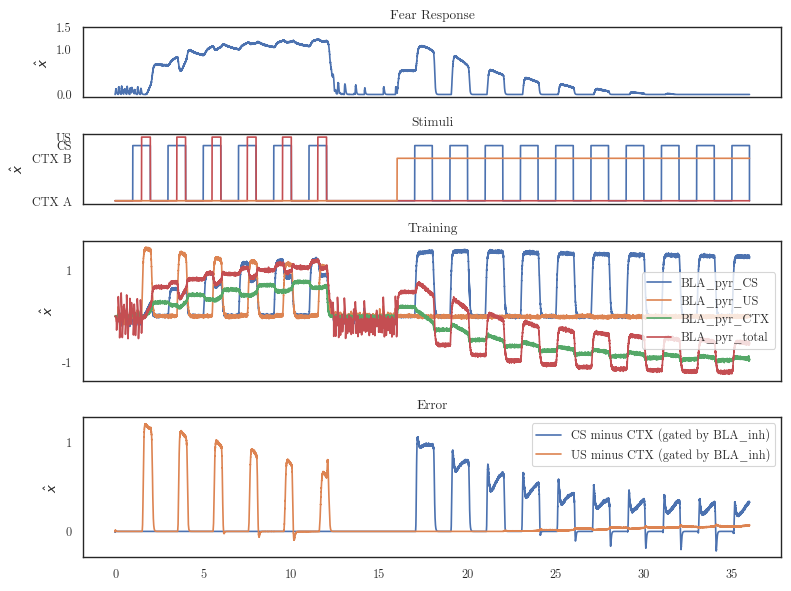

In [13]:
ctxA_idx = np.where(sim.data[pCTX]==inputs.CTXs[0])[0]
ctxB_idx = np.where(sim.data[pCTX]==inputs.CTXs[1])[0]
ctx_signal = np.zeros((sim.trange().shape[0]))
ctx_signal[ctxB_idx] = 1

fig, axes = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=((8,6)), gridspec_kw={'height_ratios': [2,2,4,4]})
axes[0].plot(sim.trange(), sim.data[pCeM])
axes[0].set(ylabel=r"$\hat{x}$", title="Fear Response", yticks=((0,1,1.5)))
axes[1].plot(sim.trange(), 1.3*np.linalg.norm(sim.data[pCS], ord=2, axis=1), label="CS present")
axes[1].plot(sim.trange(), 1.5*sim.data[pUS], label="US", c='r')
axes[1].plot(sim.trange(), ctx_signal, label="CTX")
axes[1].set(yticks=((0,1,1.3,1.5)), yticklabels=(("CTX A","CTX B","CS","US")), ylabel=r"$\hat{x}$", title="Stimuli")
# axes[2].plot(sim.trange(), sim.data[pCeL_off], label="CeL_off")
axes[2].plot(sim.trange(), sim.data[pBLA_pyr][:,0], label="BLA_pyr_CS")
axes[2].plot(sim.trange(), sim.data[pBLA_pyr][:,1], label="BLA_pyr_US")
axes[2].plot(sim.trange(), sim.data[pBLA_pyr][:,2], label="BLA_pyr_CTX")
axes[2].plot(sim.trange(), sim.data[pBLA_pyr][:,3], label="BLA_pyr_total")
axes[2].legend()
axes[2].set(yticks=((-1, 1)), yticklabels=((-1,1)), ylabel=r"$\hat{x}$", title="Training")
# axes[3].plot(sim.trange(), sim.data[pError_LA], label="US minus CS (gated by LA_inh)")
# axes[3].plot(sim.trange(), sim.data[pBLA_inh_US], label="US inhibition")
axes[3].plot(sim.trange(), sim.data[pError_BLA_safe], label="CS minus CTX (gated by BLA_inh)")
axes[3].plot(sim.trange(), sim.data[pError_BLA_fear], label="US minus CTX (gated by BLA_inh)")
axes[3].legend()
axes[3].set(ylabel=r"$\hat{x}$", title="Error", yticks=((0,1)))
plt.tight_layout()

percent fear: 29.75
percent extinction: 45.50
percent persistent: 11.75


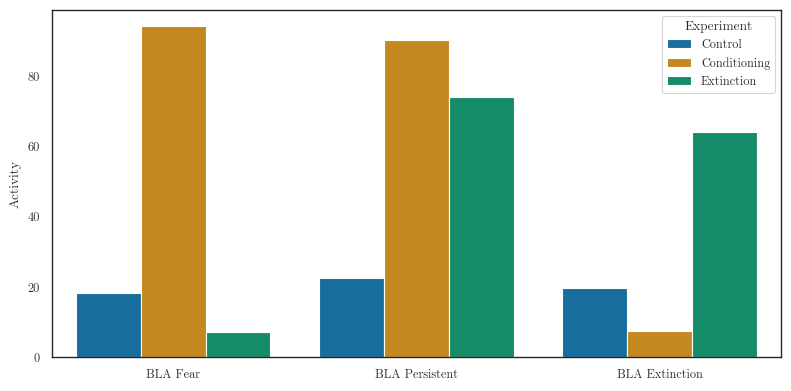

In [14]:
T1a = int(1/dt)
T1b = int(2/dt)
T4a = int((2+2*nCond-1)/dt)
T4b = int((2+2*nCond-0.5)/dt)
T5a = int((2+2*nCond+4+2*nExt-1)/dt)
T5b = int((2+2*nCond+4+2*nExt-0.5)/dt)
data_activity = pd.DataFrame(columns=["seed", "Type", "Activity", "Experiment"])

aControl_BLA = sim.data[pBLA_pyr_spikes][T1a: T1b]
aConditioning_BLA = sim.data[pBLA_pyr_spikes][T4a: T4b]
aExtinction_BLA = sim.data[pBLA_pyr_spikes][T5a: T5b]    
fear_neurons_p1 = np.where(np.mean(aConditioning_BLA, axis=0) > 1.5*np.mean(aControl_BLA, axis=0))[0]
fear_neurons_p2 = np.where(np.mean(aExtinction_BLA, axis=0) < 0.5*np.mean(aConditioning_BLA, axis=0))[0]
fear_neurons = np.intersect1d(fear_neurons_p1, fear_neurons_p2)
extinction_neurons = np.where(np.mean(aExtinction_BLA, axis=0) > 1.5*np.mean(aConditioning_BLA, axis=0))[0]
persistent_neurons = np.where(np.abs(np.mean(aConditioning_BLA-aExtinction_BLA,axis=0))<0.5*np.mean(aConditioning_BLA, axis=0))[0]

percent_fear = len(fear_neurons)/(4*nNeurons)*100
percent_extinction = len(extinction_neurons)/(4*nNeurons)*100
percent_persistent = len(persistent_neurons)/(4*nNeurons)*100

print(f"percent fear: {percent_fear:.2f}")
print(f"percent extinction: {percent_extinction:.2f}")
print(f"percent persistent: {percent_persistent:.2f}")

data_activity = data_activity.append({"seed": seed, "Type": "BLA Fear", "Activity": np.mean(aControl_BLA[:,fear_neurons]), "Experiment": "Control"}, ignore_index=True)
data_activity = data_activity.append({"seed": seed, "Type": "BLA Fear", "Activity": np.mean(aConditioning_BLA[:,fear_neurons]), "Experiment": "Conditioning"}, ignore_index=True)
data_activity = data_activity.append({"seed": seed, "Type": "BLA Fear", "Activity": np.mean(aExtinction_BLA[:,fear_neurons]), "Experiment": "Extinction"}, ignore_index=True)
data_activity = data_activity.append({"seed": seed, "Type": "BLA Persistent", "Activity": np.mean(aControl_BLA[:,persistent_neurons]), "Experiment": "Control"}, ignore_index=True)
data_activity = data_activity.append({"seed": seed, "Type": "BLA Persistent", "Activity": np.mean(aConditioning_BLA[:,persistent_neurons]), "Experiment": "Conditioning"}, ignore_index=True)
data_activity = data_activity.append({"seed": seed, "Type": "BLA Persistent", "Activity": np.mean(aExtinction_BLA[:,persistent_neurons]), "Experiment": "Extinction"}, ignore_index=True)
data_activity = data_activity.append({"seed": seed, "Type": "BLA Extinction", "Activity": np.mean(aControl_BLA[:,extinction_neurons]), "Experiment": "Control"}, ignore_index=True)
data_activity = data_activity.append({"seed": seed, "Type": "BLA Extinction", "Activity": np.mean(aConditioning_BLA[:,extinction_neurons]), "Experiment": "Conditioning"}, ignore_index=True)
data_activity = data_activity.append({"seed": seed, "Type": "BLA Extinction", "Activity": np.mean(aExtinction_BLA[:,extinction_neurons]), "Experiment": "Extinction"}, ignore_index=True)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=((8,4)))
sns.barplot(data=data_activity, x='Type', y="Activity", hue="Experiment", palette=palette, ax=ax)
ax.set(xlabel=None)
plt.tight_layout()

# Model 2 Experiments

In [15]:
def build_network(
        seed = 0,
        lr = 3e-5,
        dt = 0.001,
        nCond = 5,
        nExt = 10,
        nNeurons = 100,
        dim_CS = 3,
        dim_CTX = 5,
        nCS = 1,
        nCTX = 2,
    ):

    intercept_CS = 0
    intercept_CTX = 0
    intercept_LA_pyr = -0.5
    intercept_BLA_pyr = 0.0
    rng = np.random.RandomState(seed=seed)
    sampler = ScatteredHypersphere(surface=True)

    inputs = Inputs(dim_CS=dim_CS, dim_CTX=dim_CTX, nCS=nCS, nCTX=nCTX, seed=seed)

    intercepts_pos = nengo.dists.Uniform(0,1)
    encoders_pos = nengo.dists.Choice([[1]])
    encoders_LA_pyr = sampler.sample(2*nNeurons, 2, rng=rng)
    encoders_BLA_pyr = sampler.sample(4*nNeurons, 4, rng=rng)
    intercepts_LA_pyr = nengo.dists.Uniform(intercept_LA_pyr, intercept_LA_pyr)
    intercepts_BLA_pyr = nengo.dists.Uniform(intercept_BLA_pyr, intercept_BLA_pyr)
    encoders_CS = sampler.sample(dim_CS*nNeurons, dim_CS, rng=rng)
    encoders_CTX = sampler.sample(dim_CTX*nNeurons, dim_CTX, rng=rng)
    intercepts_CS = nengo.dists.Uniform(intercept_CS, intercept_CS)
    intercepts_CTX = nengo.dists.Uniform(intercept_CTX, intercept_CTX)
    dInh = -3e0*np.ones((nNeurons, 1))
    
    net = nengo.Network(seed=seed)
    net.config[nengo.Connection].synapse = 0.03
    net.config[nengo.Probe].synapse = 0.03

    with net:
        # inputs and outputs
        CS = nengo.Node(lambda t, x: inputs.get_CS(t), size_in=2)
        US = nengo.Node(lambda t, x: inputs.get_US(t), size_in=2)
        CTX = nengo.Node(lambda t, x: inputs.get_CTX(t), size_in=2, size_out=dim_CTX)
        bias = nengo.Node(lambda t: 0.5)
        stop_learning = nengo.Node(lambda t, x: inputs.get_stop_learning(t), size_in=2)
        applied_current = nengo.Node(lambda t, x: inputs.get_applied_current(t), size_in=2)
        # external ensembles
        external_CS = nengo.Ensemble(dim_CS*nNeurons, dim_CS, intercepts=intercepts_CS, encoders=encoders_CS)
        external_US = nengo.Ensemble(nNeurons, 1)
        external_CTX = nengo.Ensemble(dim_CTX*nNeurons, dim_CTX, intercepts=intercepts_CTX, encoders=encoders_CTX)
        # amygdala ensembles
        LA_pyr = nengo.Ensemble(2*nNeurons, 2, encoders=encoders_LA_pyr, intercepts=intercepts_LA_pyr)  # [CS, US]
        LA_inh = nengo.Ensemble(2*nNeurons, 2)  # [CS, US]
        CeL_on = nengo.Ensemble(nNeurons, 1, intercepts=intercepts_pos, encoders=encoders_pos)  # [CS]
        CeL_off = nengo.Ensemble(nNeurons, 1, intercepts=intercepts_pos, encoders=encoders_pos)  # [bias-CS]
        CeM = nengo.Ensemble(nNeurons, 1, intercepts=intercepts_pos, encoders=encoders_pos)
        BLA_pyr = nengo.Ensemble(4*nNeurons, 4, radius=4, encoders=encoders_BLA_pyr, intercepts=intercepts_BLA_pyr)  # [CS, US, CTX]
        BLA_inh = nengo.Ensemble(2*nNeurons, 2, radius=2)  # [CS, US]
        # error ensembles
        error_LA = nengo.Ensemble(nNeurons, 1)
        error_CeL = nengo.Ensemble(nNeurons, 1)
        error_BLA_safe = nengo.Ensemble(nNeurons, 1)
        error_BLA_fear = nengo.Ensemble(nNeurons, 1)
        # external connections
        nengo.Connection(CS, external_CS, synapse=None)
        nengo.Connection(US, external_US, synapse=None)
        nengo.Connection(external_CS, LA_inh[0], function=lambda x: np.sum(np.square(x)))  # any CS present
        nengo.Connection(external_US, LA_inh[1])
        nengo.Connection(external_US, LA_pyr[1])
        nengo.Connection(bias, CeL_off, transform=1)
        nengo.Connection(bias, CeM)
        nengo.Connection(CTX, external_CTX, synapse=None)
        # internal connections
        nengo.Connection(CeL_on, CeL_off, transform=-1)
        nengo.Connection(CeL_off, CeM, transform=-1)
        nengo.Connection(LA_pyr, BLA_pyr[:2])  # communicate [CS, US]
        nengo.Connection(BLA_pyr[:2], BLA_inh)  # communicate [CS,US]
        nengo.Connection(BLA_pyr[0], BLA_pyr[3], transform=0.25)  # CS response added to total fear response
        nengo.Connection(BLA_pyr[2], BLA_pyr[3], transform=0.75)  # CTX response added to total fear response
        nengo.Connection(BLA_pyr[3], CeM)  # communicate total fear response to CeM
        # learned connections
        conditioning = nengo.Connection(external_CS, LA_pyr[0], function=lambda x: 0, learning_rule_type=nengo.PES(lr))
        transmission = nengo.Connection(LA_pyr[0], CeL_on, function=lambda x: 0, learning_rule_type=nengo.PES(lr))
        extinction = nengo.Connection(external_CTX, BLA_pyr[2], function=lambda x: 0, learning_rule_type=nengo.PES(0.08*lr))
        # error connections
        nengo.Connection(LA_pyr, error_LA, function=lambda x: x[1]-x[0])  # US - CS response
        nengo.Connection(LA_pyr[0], error_CeL, transform=+1)  # LA_pyr CS response
        nengo.Connection(CeL_on, error_CeL, transform=-1)  # -CeL_on CS response
        nengo.Connection(BLA_pyr, error_BLA_safe, function=lambda x: x[0]+x[2])  # CS response + (-) CTX response
        nengo.Connection(BLA_pyr, error_BLA_fear, function=lambda x: x[1]-x[2])   # US response - CTX response
        # error gating
        nengo.Connection(LA_inh, error_LA.neurons, function=lambda x: x[0]-x[1], transform=dInh)  # inhibit if only CS present
        nengo.Connection(BLA_inh, error_BLA_safe.neurons, function=lambda x: 1-x[0], transform=dInh)  # inhibit by default; release if CS
        nengo.Connection(BLA_inh, error_BLA_safe.neurons, function=lambda x: x[1], transform=10*dInh, synapse=1.0)  # inhibit if recent US
        nengo.Connection(BLA_inh, error_BLA_fear.neurons, function=lambda x: 1-1.2*x[1], transform=0.5*dInh)  # slow learning unless US
        # error updating
        nengo.Connection(error_LA, conditioning.learning_rule, transform=-1)
        nengo.Connection(error_CeL, transmission.learning_rule, transform=-1)
        nengo.Connection(error_BLA_safe, extinction.learning_rule, transform=1)
        nengo.Connection(error_BLA_fear, extinction.learning_rule, transform=-1)
        # prevent learning during testing
        nengo.Connection(stop_learning, error_LA.neurons, transform=dInh)
        nengo.Connection(stop_learning, error_CeL.neurons, transform=dInh)
        nengo.Connection(stop_learning, error_BLA_safe.neurons, transform=dInh)
        nengo.Connection(stop_learning, error_BLA_fear.neurons, transform=dInh)

        # probes
        net.pCS = nengo.Probe(CS, synapse=None)
        net.pUS = nengo.Probe(US, synapse=None)
        net.pCTX = nengo.Probe(CTX, synapse=None)
        net.pLA_pyr_spikes = nengo.Probe(LA_pyr.neurons)
        net.pLA_inh_spikes = nengo.Probe(LA_inh.neurons)
        net.pCeL_on_spikes = nengo.Probe(CeL_on.neurons)
        net.pCeL_off_spikes = nengo.Probe(CeL_off.neurons)
        net.pCeM_spikes = nengo.Probe(CeM.neurons)
        net.pBLA_pyr_spikes = nengo.Probe(BLA_pyr.neurons)
        net.pBLA_inh_spikes = nengo.Probe(BLA_inh.neurons)
        net.pBLA_pyr = nengo.Probe(BLA_pyr)
        net.pBLA_inh = nengo.Probe(BLA_inh)
        net.pLA_pyr = nengo.Probe(LA_pyr)
        net.pLA_inh = nengo.Probe(LA_inh)
        net.pCeL_on = nengo.Probe(CeL_on)
        net.pCeL_off = nengo.Probe(CeL_off)
        net.pCeM = nengo.Probe(CeM)
        net.pError_LA = nengo.Probe(error_LA)
        net.pError_CeL = nengo.Probe(error_CeL)
        net.pBLA_pyr = nengo.Probe(BLA_pyr)
        net.pBLA_inh = nengo.Probe(BLA_inh)
        net.pError_BLA_safe = nengo.Probe(error_BLA_safe)
        net.pError_BLA_fear = nengo.Probe(error_BLA_fear)
        
        # save pointers
        net.inputs = inputs
        net.applied_current = applied_current
        net.LA_pyr = LA_pyr
        net.LA_inh = LA_inh
        net.CeL_on = CeL_on
        net.CeL_off = CeL_off
        net.CeM = CeM
        net.BLA_pyr = BLA_pyr
        net.BLA_inh = BLA_inh
        net.error_LA = error_LA
        net.error_CeL = error_CeL
        net.error_BLA_safe = error_BLA_safe
        net.error_BLA_fear = error_BLA_fear
        
    return net

### Baseline experiment: behavioral and activity data for normal conditioning, extinction, and testing

In [16]:
def run_baseline(
        seeds=2,
        nNeurons=100,
        seed=0,
        learning_rate=3e-5,
        dt=1e-3,
        nCond=5,
        nExt=10,
        dim_CS=3,
        dim_CTX=5,
        nCS=1,
        nCTX=3,
    ):

    data_fear = pd.DataFrame(columns=["seed", "Fear Response", "Experiment"])
    data_activity = pd.DataFrame(columns=["seed", "Type", "Activity", "Experiment"])
    data_response = pd.DataFrame(columns=["seed", "Type", "Percent"])
    rng = np.random.RandomState(seeds)

    for s in range(seeds):
        print(f"seed={s}")
        seed = s
        lr = np.abs(rng.normal(learning_rate, learning_rate/10))
        net = build_network(seed=seed, lr=lr, dt=dt, nNeurons=nNeurons,
                           nCond=nCond, nExt=nExt, dim_CS=dim_CS, nCTX=nCTX, nCS=nCS)
        sim = nengo.Simulator(net, dt=dt, progress_bar=False)
        with sim:
            net.inputs.stop_learning = 0
            print("control")
            net.inputs.CTX = net.inputs.CTXs[0]
            sim.run(2)
            T1a = int(1/dt)
            T1b = int(2/dt)
            print("conditioning")
            net.inputs.CTX = net.inputs.CTXs[0]
            net.inputs.US = 1
            for p in range(nCond):
                sim.run(2)
            T2a = int((2+2*nCond-1)/dt)
            T2b = int((2+2*nCond-0.5)/dt)
            print("pause")
            net.inputs.pause = True
            net.inputs.CTX = np.zeros((dim_CTX))
            net.inputs.US = 0
            sim.run(4)
            net.inputs.pause = False
            print("extinction")
            net.inputs.CTX = net.inputs.CTXs[1]
            net.inputs.US = 0
            for p in range(nExt):
                sim.run(2)
            T3a = int((2+2*nCond+4+2*nExt-1)/dt)
            T3b = int((2+2*nCond+4+2*nExt-0.5)/dt)
    #         print("turn learning off for testing")
            net.inputs.stop_learning = 1
            print("test CTX A")
            net.inputs.CTX = net.inputs.CTXs[0]
            net.inputs.US = 0
            sim.run(2)
            T4a = int((2+2*nCond+4+2*nExt+1)/dt)
            T4b = int((2+2*nCond+4+2*nExt+1.5)/dt)
            print("test CTX B")
            net.inputs.CTX = net.inputs.CTXs[1]
            net.inputs.US = 0
            sim.run(2)
            T5a = int((2+2*nCond+4+2*nExt+2+1)/dt)
            T5b = int((2+2*nCond+4+2*nExt+2+1.5)/dt)  
            print("test CTX C")
            net.inputs.CTX = net.inputs.CTXs[2]
            net.inputs.US = 0
            sim.run(2)
            T6a = int((2+2*nCond+4+2*nExt+2+2+1)/dt)
            T6b = int((2+2*nCond+4+2*nExt+2+2+1.5)/dt)  

            
#         ctxA_idx = np.where(sim.data[net.pCTX]==net.inputs.CTXs[0])[0]
#         ctxB_idx = np.where(sim.data[net.pCTX]==net.inputs.CTXs[1])[0]
#         ctx_signal = np.zeros((sim.trange().shape[0]))
#         ctx_signal[ctxB_idx] = 1
#         fig, axes = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=((8,6)), gridspec_kw={'height_ratios': [2,2,4,4]})
#         axes[0].plot(sim.trange(), sim.data[net.pCeM])
#         axes[0].set(ylabel=r"$\hat{x}$", title="Fear Response", yticks=((0,1)))
#         axes[1].plot(sim.trange(), 1.3*np.linalg.norm(sim.data[net.pCS], ord=2, axis=1), label="CS present")
#         axes[1].plot(sim.trange(), 1.5*sim.data[net.pUS], label="US", c='r')
#         axes[1].plot(sim.trange(), ctx_signal, label="CTX")
#         axes[1].set(yticks=((0,1,1.3,1.5)), yticklabels=(("CTX A","CTX B","CS","US")), ylabel=r"$\hat{x}$", title="Stimuli")
#         axes[2].plot(sim.trange(), sim.data[net.pBLA_pyr][:,0], label="BLA_pyr_CS")
#         axes[2].plot(sim.trange(), sim.data[net.pBLA_pyr][:,1], label="BLA_pyr_US")
#         axes[2].plot(sim.trange(), sim.data[net.pBLA_pyr][:,2], label="BLA_pyr_CTX")
#         axes[2].plot(sim.trange(), sim.data[net.pBLA_pyr][:,3], label="BLA_pyr_total")
#         axes[2].legend()
#         axes[2].set(yticks=((-1, 1)), yticklabels=((-1,1)), ylabel=r"$\hat{x}$", title="Training")
#         axes[3].plot(sim.trange(), sim.data[net.pError_BLA_safe], label="CS minus CTX (gated by BLA_inh)")
#         axes[3].plot(sim.trange(), sim.data[net.pError_BLA_fear], label="US minus CTX (gated by BLA_inh)")
#         axes[3].legend()
#         axes[3].set(ylabel=r"$\hat{x}$", title="Error", yticks=((0,1)))
#         plt.tight_layout()
            
        data_fear = data_fear.append({
            "Fear Response": np.mean(sim.data[net.pCeM][T1a: T1b]),
            "Experiment": "Control"},
            ignore_index=True)
        data_fear = data_fear.append({
            "Fear Response": np.mean(sim.data[net.pCeM][T4a: T4b]),
            "Experiment": "CS+ and CTX+"},
            ignore_index=True)
        data_fear = data_fear.append({
            "Fear Response": np.mean(sim.data[net.pCeM][T5a: T5b]),
            "Experiment": "CS+ and CTX-"},
            ignore_index=True)
        data_fear = data_fear.append({
            "Fear Response": np.mean(sim.data[net.pCeM][T6a: T6b]),
            "Experiment": "CS+ and CTX new"},
            ignore_index=True)
            
        aControl_LA_pyr = sim.data[net.pLA_pyr_spikes][T1a: T1b]
        aConditioning_LA_pyr = sim.data[net.pLA_pyr_spikes][T4a: T4b]
        aExtinction_LA_pyr = sim.data[net.pLA_pyr_spikes][T5a: T5b]
        aControl_CeL_on = sim.data[net.pCeL_on_spikes][T1a: T1b]
        aConditioning_CeL_on = sim.data[net.pCeL_on_spikes][T4a: T4b]
        aExtinction_CeL_on = sim.data[net.pCeL_on_spikes][T5a: T5b]
        aControl_CeL_off = sim.data[net.pCeL_off_spikes][T1a: T1b]
        aConditioning_CeL_off = sim.data[net.pCeL_off_spikes][T4a: T4b]
        aExtinction_CeL_off = sim.data[net.pCeL_off_spikes][T5a: T5b]
        aControl_BLA = sim.data[net.pBLA_pyr_spikes][T1a: T1b]
        aConditioning_BLA = sim.data[net.pBLA_pyr_spikes][T4a: T4b]
        aExtinction_BLA = sim.data[net.pBLA_pyr_spikes][T5a: T5b]    
        
        LA_pyr_up = np.where(np.mean(aConditioning_LA_pyr, axis=0) > 1.5*np.mean(aControl_LA_pyr, axis=0))[0]
        LA_pyr_down = np.where(np.mean(aConditioning_LA_pyr, axis=0) < 0.5*np.mean(aControl_LA_pyr, axis=0))[0]
        fear_neurons_p1 = np.where(np.mean(aConditioning_BLA, axis=0) > 1.5*np.mean(aControl_BLA, axis=0))[0]
        fear_neurons_p2 = np.where(np.mean(aExtinction_BLA, axis=0) < 0.5*np.mean(aConditioning_BLA, axis=0))[0]
        fear_neurons = np.intersect1d(fear_neurons_p1, fear_neurons_p2)
        extinction_neurons = np.where(np.mean(aExtinction_BLA, axis=0) > 1.5*np.mean(aConditioning_BLA, axis=0))[0]
        persistent_neurons = np.where(np.abs(np.mean(aConditioning_BLA-aExtinction_BLA,axis=0))<0.5*np.mean(aConditioning_BLA, axis=0))[0]

        data_activity = data_activity.append({"seed": seed, "Type": "LA up", "Activity": np.mean(aControl_LA_pyr[:,LA_pyr_up]), "Experiment": "Control"}, ignore_index=True)
        data_activity = data_activity.append({"seed": seed, "Type": "LA up", "Activity": np.mean(aConditioning_LA_pyr[:,LA_pyr_up]), "Experiment": "Conditioning"}, ignore_index=True)
        data_activity = data_activity.append({"seed": seed, "Type": "LA up", "Activity": np.mean(aExtinction_LA_pyr[:,LA_pyr_up]), "Experiment": "Extinction"}, ignore_index=True)
        data_activity = data_activity.append({"seed": seed, "Type": "LA down", "Activity": np.mean(aControl_LA_pyr[:,LA_pyr_down]), "Experiment": "Control"}, ignore_index=True)
        data_activity = data_activity.append({"seed": seed, "Type": "LA down", "Activity": np.mean(aConditioning_LA_pyr[:,LA_pyr_down]), "Experiment": "Conditioning"}, ignore_index=True)
        data_activity = data_activity.append({"seed": seed, "Type": "LA down", "Activity": np.mean(aExtinction_LA_pyr[:,LA_pyr_down]), "Experiment": "Extinction"}, ignore_index=True)
        data_activity = data_activity.append({"seed": seed, "Type": "BLA Fear", "Activity": np.mean(aControl_BLA[:,fear_neurons]), "Experiment": "Control"}, ignore_index=True)
        data_activity = data_activity.append({"seed": seed, "Type": "BLA Fear", "Activity": np.mean(aConditioning_BLA[:,fear_neurons]), "Experiment": "Conditioning"}, ignore_index=True)
        data_activity = data_activity.append({"seed": seed, "Type": "BLA Fear", "Activity": np.mean(aExtinction_BLA[:,fear_neurons]), "Experiment": "Extinction"}, ignore_index=True)
        data_activity = data_activity.append({"seed": seed, "Type": "BLA Persistent", "Activity": np.mean(aControl_BLA[:,persistent_neurons]), "Experiment": "Control"}, ignore_index=True)
        data_activity = data_activity.append({"seed": seed, "Type": "BLA Persistent", "Activity": np.mean(aConditioning_BLA[:,persistent_neurons]), "Experiment": "Conditioning"}, ignore_index=True)
        data_activity = data_activity.append({"seed": seed, "Type": "BLA Persistent", "Activity": np.mean(aExtinction_BLA[:,persistent_neurons]), "Experiment": "Extinction"}, ignore_index=True)
        data_activity = data_activity.append({"seed": seed, "Type": "BLA Extinction", "Activity": np.mean(aControl_BLA[:,extinction_neurons]), "Experiment": "Control"}, ignore_index=True)
        data_activity = data_activity.append({"seed": seed, "Type": "BLA Extinction", "Activity": np.mean(aConditioning_BLA[:,extinction_neurons]), "Experiment": "Conditioning"}, ignore_index=True)
        data_activity = data_activity.append({"seed": seed, "Type": "BLA Extinction", "Activity": np.mean(aExtinction_BLA[:,extinction_neurons]), "Experiment": "Extinction"}, ignore_index=True)
        data_activity = data_activity.append({"seed": seed, "Type": "CeL on", "Activity": np.mean(aControl_CeL_on), "Experiment": "Control"}, ignore_index=True)
        data_activity = data_activity.append({"seed": seed, "Type": "CeL on", "Activity": np.mean(aConditioning_CeL_on), "Experiment": "Conditioning"}, ignore_index=True)
        data_activity = data_activity.append({"seed": seed, "Type": "CeL on", "Activity": np.mean(aExtinction_CeL_on), "Experiment": "Extinction"}, ignore_index=True)
        data_activity = data_activity.append({"seed": seed, "Type": "CeL off", "Activity": np.mean(aControl_CeL_off), "Experiment": "Control"}, ignore_index=True)
        data_activity = data_activity.append({"seed": seed, "Type": "CeL off", "Activity": np.mean(aConditioning_CeL_off), "Experiment": "Conditioning"}, ignore_index=True)
        data_activity = data_activity.append({"seed": seed, "Type": "CeL off", "Activity": np.mean(aExtinction_CeL_off), "Experiment": "Extinction"}, ignore_index=True)

        percent_up = len(LA_pyr_up)/(2*nNeurons)*100
        percent_down = len(LA_pyr_down)/(2*nNeurons)*100
        percent_fear = len(fear_neurons)/(4*nNeurons)*100
        percent_extinction = len(extinction_neurons)/(4*nNeurons)*100
        percent_persistent = len(persistent_neurons)/(4*nNeurons)*100
        data_response = data_response.append({"seed": seed, "Type": "LA up", "Percent": percent_up}, ignore_index=True)
        data_response = data_response.append({"seed": seed, "Type": "LA down", "Percent": percent_down}, ignore_index=True)
        data_response = data_response.append({"seed": seed, "Type": "BLA Fear", "Percent": percent_fear}, ignore_index=True)
        data_response = data_response.append({"seed": seed, "Type": "BLA Extinction", "Percent": percent_extinction}, ignore_index=True)
        data_response = data_response.append({"seed": seed, "Type": "BLA Persistent", "Percent": percent_persistent}, ignore_index=True)

    fig, ax = plt.subplots(figsize=((8,4)))
    sns.barplot(data=data_fear, x='Experiment', y="Fear Response", palette=palette)
    ax.set(xlabel=None, yticks=((0,1)), title="Behavioral Data")
    plt.tight_layout()
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=((8,4)))
    sns.barplot(data=data_activity, x='Type', y="Activity", hue="Experiment", palette=palette, ax=ax)
    ax.set(xlabel=None)
    plt.tight_layout()
    
    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=((8,4)), sharey=True)
    sns.histplot(data=data_response.query("Type=='LA up'")['Percent'], bins=10, ax=axes[0])
    sns.histplot(data=data_response.query("Type=='LA down'")['Percent'], bins=10, ax=axes[1])
    sns.histplot(data=data_response.query("Type=='BLA Fear'")['Percent'], bins=10, ax=axes[2])
    sns.histplot(data=data_response.query("Type=='BLA Persistent'")['Percent'], bins=10, ax=axes[3])
    sns.histplot(data=data_response.query("Type=='BLA Extinction'")['Percent'], bins=10, ax=axes[4])
    axes[0].set(title="LA CS Up")
    axes[1].set(title="LA CS Down")
    axes[2].set(title="BLA Fear")
    axes[3].set(title="BLA Persistent")
    axes[4].set(title="BLA Extinction")
    plt.tight_layout()

seed=0
control
conditioning
pause
extinction
test CTX A
test CTX B
test CTX C
seed=1
control
conditioning
pause
extinction
test CTX A
test CTX B
test CTX C
seed=2
control
conditioning
pause
extinction
test CTX A
test CTX B
test CTX C
seed=3
control
conditioning
pause
extinction
test CTX A
test CTX B
test CTX C
seed=4
control
conditioning
pause
extinction
test CTX A
test CTX B
test CTX C


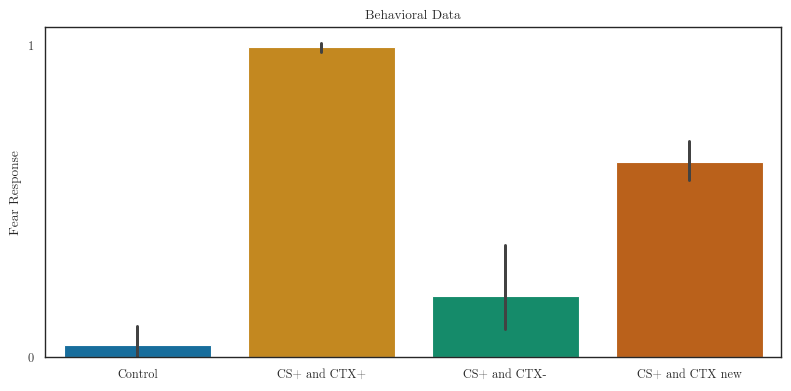

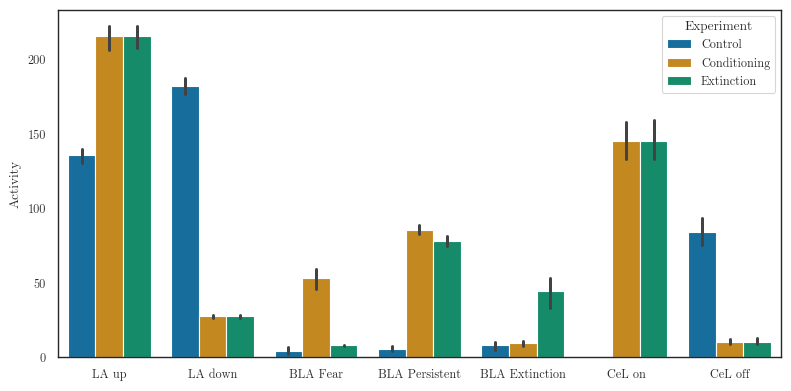

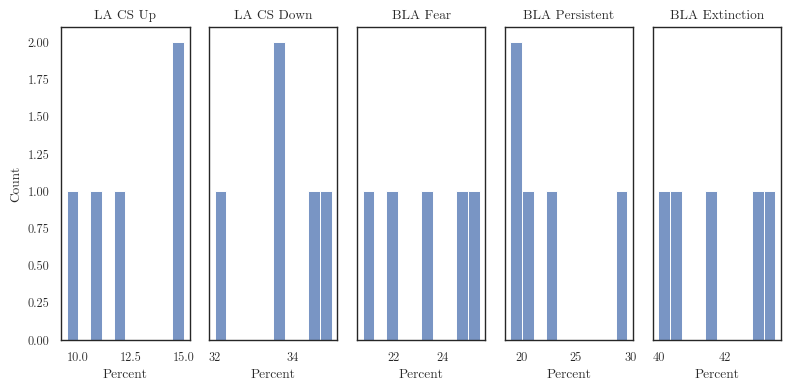

In [17]:
run_baseline(seeds=5)

## Activation and Inactivation Experiments

In [18]:
def run_once(seed, target, block, stim, data_behavior, data_activity, data_response,
        nNeurons=100,
        learning_rate=3e-5,
        dt=1e-3,
        nCond=5,
        nExt=10,
        dim_CS=3,
        dim_CTX=5,
        nCTX=2,
        T_current=2e0,
    ):

    print(f"seed={seed}, target={target}, block={block}, stim={stim}")
    lr = np.random.RandomState(seed=seed).uniform(learning_rate/3, learning_rate*3)
    net = build_network(seed=seed, lr=lr, dt=dt, nNeurons=nNeurons,
                       nCond=nCond, nExt=nExt, dim_CS=dim_CS, nCTX=nCTX, nCS=nCS)
    with net:
        if target=="LA_pyr":
            nengo.Connection(net.applied_current, net.LA_pyr.neurons, transform=T_current*np.ones((2*nNeurons, 1)))
        if target=="LA_inh":
            nengo.Connection(net.applied_current, net.LA_inh.neurons, transform=T_current*np.ones((2*nNeurons, 1)))
        if target=="BLA_pyr":
            nengo.Connection(net.applied_current, net.BLA_pyr.neurons, transform=T_current*np.ones((4*nNeurons, 1)))
        if target=="BLA_inh":
            nengo.Connection(net.applied_current, net.BLA_inh.neurons, transform=2*T_current*np.ones((2*nNeurons, 1)))
        if target=="CeL":
            nengo.Connection(net.applied_current, net.CeL_on.neurons, transform=T_current*np.ones((nNeurons, 1)))
            nengo.Connection(net.applied_current, net.CeL_off.neurons, transform=T_current*np.ones((nNeurons, 1)))
        if target=="CeM":
            nengo.Connection(net.applied_current, net.CeM.neurons, transform=T_current*np.ones((nNeurons, 1)))
    sim = nengo.Simulator(net, dt=dt, progress_bar=False)
    with sim:
        # control
        net.inputs.CTX = net.inputs.CTXs[0]
        net.inputs.US = 0
        if block=="Before Training" and stim=="Activate":
            net.inputs.applied_current = 1
        elif block=="Before Training" and stim=="Inactivate":
            net.inputs.applied_current = -1
        else:
            net.inputs.applied_current = 0
        sim.run(2)
        T1a = int(1/dt)
        T1b = int(2/dt)
        # conditioning
        net.inputs.CTX = net.inputs.CTXs[0]
        net.inputs.US = 1
        if block=="Conditioning Training" and stim=="Activate":
            net.inputs.applied_current = 1
        elif block=="Conditioning Training" and stim=="Inactivate":
            net.inputs.applied_current = -1
        else:
            net.inputs.applied_current = 0
        for p in range(nCond):
            sim.run(2)
        T2a = int((2)/dt)
        T2b = int((2+2*nCond)/dt)
        # test (conditioning)
        net.inputs.CTX = net.inputs.CTXs[0]
        net.inputs.US = 0
        if block=="Conditioning Testing" and stim=="Activate":
            net.inputs.applied_current = 1
        elif block=="Conditioning Testing" and stim=="Inactivate":
            net.inputs.applied_current = -1
        else:
            net.inputs.applied_current = 0
        sim.run(2)
        T3a = int((2+2*nCond+1)/dt)
        T3b = int((2+2*nCond+2)/dt)
        # pause
        net.inputs.pause = True
        net.inputs.CTX = np.zeros((dim_CTX))
        net.inputs.US = 0
        sim.run(4)
        net.inputs.pause = False        
        # extinction 
        net.inputs.CTX = net.inputs.CTXs[1]
        net.inputs.US = 0
        if block=="Extinction Training" and stim=="Activate":
            net.inputs.applied_current = 1
        elif block=="Extinction Training" and stim=="Inactivate":
            net.inputs.applied_current = -1
        else:
            net.inputs.applied_current = 0
        for p in range(nExt):
            sim.run(2)
        T4a = int((2+2*nCond+2+4)/dt)
        T4b = int((2+2*nCond+2+4+2*nExt)/dt)
        # test (extinction)
        net.inputs.CTX = net.inputs.CTXs[1]
        net.inputs.US = 0
        if block=="Extinction Testing" and stim=="Activate":
            net.inputs.applied_current = 1
        elif block=="Extinction Testing" and stim=="Inactivate":
            net.inputs.applied_current = -1
        else:
            net.inputs.applied_current = 0
        sim.run(2)
        T5a = int((2+2*nCond+2+4+2*nExt+1)/dt)
        T5b = int((2+2*nCond+2+4+2*nExt+2)/dt)


    data_behavior = data_behavior.append({"seed": seed, "Test" :"Spontaneous", "Fear Response": np.mean(sim.data[net.pCeM][T1a: T1b]), "Target": target, "Stimulus": stim, "Block": block},ignore_index=True)
    data_behavior = data_behavior.append({"seed": seed, "Test" :"Conditioning", "Fear Response": np.mean(sim.data[net.pCeM][T3a: T3b]), "Target": target, "Stimulus": stim, "Block": block}, ignore_index=True)
    data_behavior = data_behavior.append({"seed": seed, "Test" :"Extinction", "Fear Response": np.mean(sim.data[net.pCeM][T5a: T5b]), "Target": target, "Stimulus": stim, "Block": block}, ignore_index=True)

    aControl_LA_pyr = sim.data[net.pLA_pyr_spikes][T1a: T1b]
    aConditioning_LA_pyr = sim.data[net.pLA_pyr_spikes][T3a: T3b]
    aExtinction_LA_pyr = sim.data[net.pLA_pyr_spikes][T5a: T5b]
    aControl_CeL_on = sim.data[net.pCeL_on_spikes][T1a: T1b]
    aConditioning_CeL_on = sim.data[net.pCeL_on_spikes][T3a: T3b]
    aExtinction_CeL_on = sim.data[net.pCeL_on_spikes][T5a: T5b]
    aControl_CeL_off = sim.data[net.pCeL_off_spikes][T1a: T1b]
    aConditioning_CeL_off = sim.data[net.pCeL_off_spikes][T3a: T3b]
    aExtinction_CeL_off = sim.data[net.pCeL_off_spikes][T5a: T5b]
    aControl_BLA = sim.data[net.pBLA_pyr_spikes][T1a: T1b]
    aConditioning_BLA = sim.data[net.pBLA_pyr_spikes][T3a: T3b]
    aExtinction_BLA = sim.data[net.pBLA_pyr_spikes][T5a: T5b]    

    LA_pyr_up = np.where(np.mean(aConditioning_LA_pyr, axis=0) > 1.5*np.mean(aControl_LA_pyr, axis=0))[0]
    LA_pyr_down = np.where(np.mean(aConditioning_LA_pyr, axis=0) < 0.5*np.mean(aControl_LA_pyr, axis=0))[0]
    fear_neurons_p1 = np.where(np.mean(aConditioning_BLA, axis=0) > 1.5*np.mean(aControl_BLA, axis=0))[0]
    fear_neurons_p2 = np.where(np.mean(aExtinction_BLA, axis=0) < 0.5*np.mean(aConditioning_BLA, axis=0))[0]
    fear_neurons = np.intersect1d(fear_neurons_p1, fear_neurons_p2)
    extinction_neurons = np.where(np.mean(aExtinction_BLA, axis=0) > 1.5*np.mean(aConditioning_BLA, axis=0))[0]
    persistent_neurons = np.where(np.abs(np.mean(aConditioning_BLA-aExtinction_BLA,axis=0))<0.5*np.mean(aConditioning_BLA, axis=0))[0]

    data_activity = data_activity.append({"seed": seed, "Type": "LA up", "Activity": np.mean(aControl_LA_pyr[:,LA_pyr_up]), "Target": target, "Stimulus": stim, "Block": block}, ignore_index=True)
    data_activity = data_activity.append({"seed": seed, "Type": "LA up", "Activity": np.mean(aConditioning_LA_pyr[:,LA_pyr_up]), "Target": target, "Stimulus": stim, "Block": block}, ignore_index=True)
    data_activity = data_activity.append({"seed": seed, "Type": "LA up", "Activity": np.mean(aExtinction_LA_pyr[:,LA_pyr_up]), "Target": target, "Stimulus": stim, "Block": block}, ignore_index=True)
    data_activity = data_activity.append({"seed": seed, "Type": "LA down", "Activity": np.mean(aControl_LA_pyr[:,LA_pyr_down]), "Target": target, "Stimulus": stim, "Block": block}, ignore_index=True)
    data_activity = data_activity.append({"seed": seed, "Type": "LA down", "Activity": np.mean(aConditioning_LA_pyr[:,LA_pyr_down]), "Target": target, "Stimulus": stim, "Block": block}, ignore_index=True)
    data_activity = data_activity.append({"seed": seed, "Type": "LA down", "Activity": np.mean(aExtinction_LA_pyr[:,LA_pyr_down]), "Target": target, "Stimulus": stim, "Block": block}, ignore_index=True)
    data_activity = data_activity.append({"seed": seed, "Type": "BLA Fear", "Activity": np.mean(aControl_BLA[:,fear_neurons]), "Target": target, "Stimulus": stim, "Block": block}, ignore_index=True)
    data_activity = data_activity.append({"seed": seed, "Type": "BLA Fear", "Activity": np.mean(aConditioning_BLA[:,fear_neurons]), "Target": target, "Stimulus": stim, "Block": block}, ignore_index=True)
    data_activity = data_activity.append({"seed": seed, "Type": "BLA Fear", "Activity": np.mean(aExtinction_BLA[:,fear_neurons]), "Target": target, "Stimulus": stim, "Block": block}, ignore_index=True)
    data_activity = data_activity.append({"seed": seed, "Type": "BLA Persistent", "Activity": np.mean(aControl_BLA[:,persistent_neurons]), "Target": target, "Stimulus": stim, "Block": block}, ignore_index=True)
    data_activity = data_activity.append({"seed": seed, "Type": "BLA Persistent", "Activity": np.mean(aConditioning_BLA[:,persistent_neurons]), "Target": target, "Stimulus": stim, "Block": block}, ignore_index=True)
    data_activity = data_activity.append({"seed": seed, "Type": "BLA Persistent", "Activity": np.mean(aExtinction_BLA[:,persistent_neurons]), "Target": target, "Stimulus": stim, "Block": block}, ignore_index=True)
    data_activity = data_activity.append({"seed": seed, "Type": "BLA Extinction", "Activity": np.mean(aControl_BLA[:,extinction_neurons]), "Target": target, "Stimulus": stim, "Block": block}, ignore_index=True)
    data_activity = data_activity.append({"seed": seed, "Type": "BLA Extinction", "Activity": np.mean(aConditioning_BLA[:,extinction_neurons]), "Target": target, "Stimulus": stim, "Block": block}, ignore_index=True)
    data_activity = data_activity.append({"seed": seed, "Type": "BLA Extinction", "Activity": np.mean(aExtinction_BLA[:,extinction_neurons]), "Target": target, "Stimulus": stim, "Block": block}, ignore_index=True)
    data_activity = data_activity.append({"seed": seed, "Type": "CeL on", "Activity": np.mean(aControl_CeL_on), "Target": target, "Stimulus": stim, "Block": block}, ignore_index=True)
    data_activity = data_activity.append({"seed": seed, "Type": "CeL on", "Activity": np.mean(aConditioning_CeL_on), "Target": target, "Stimulus": stim, "Block": block}, ignore_index=True)
    data_activity = data_activity.append({"seed": seed, "Type": "CeL on", "Activity": np.mean(aExtinction_CeL_on), "Target": target, "Stimulus": stim, "Block": block}, ignore_index=True)
    data_activity = data_activity.append({"seed": seed, "Type": "CeL off", "Activity": np.mean(aControl_CeL_off), "Target": target, "Stimulus": stim, "Block": block}, ignore_index=True)
    data_activity = data_activity.append({"seed": seed, "Type": "CeL off", "Activity": np.mean(aConditioning_CeL_off), "Target": target, "Stimulus": stim, "Block": block}, ignore_index=True)
    data_activity = data_activity.append({"seed": seed, "Type": "CeL off", "Activity": np.mean(aExtinction_CeL_off), "Target": target, "Stimulus": stim, "Block": block}, ignore_index=True)

    percent_up = len(LA_pyr_up)/(2*nNeurons)*100
    percent_down = len(LA_pyr_down)/(2*nNeurons)*100
    percent_fear = len(fear_neurons)/(4*nNeurons)*100
    percent_extinction = len(extinction_neurons)/(4*nNeurons)*100
    percent_persistent = len(persistent_neurons)/(4*nNeurons)*100
    data_response = data_response.append({"seed": seed, "Type": "LA up", "Percent": percent_up, "Target": target, "Stimulus": stim, "Block": block}, ignore_index=True)
    data_response = data_response.append({"seed": seed, "Type": "LA down", "Percent": percent_down, "Target": target, "Stimulus": stim, "Block": block}, ignore_index=True)
    data_response = data_response.append({"seed": seed, "Type": "BLA Fear", "Percent": percent_fear, "Target": target, "Stimulus": stim, "Block": block}, ignore_index=True)
    data_response = data_response.append({"seed": seed, "Type": "BLA Extinction", "Percent": percent_extinction, "Target": target, "Stimulus": stim, "Block": block}, ignore_index=True)
    data_response = data_response.append({"seed": seed, "Type": "BLA Persistent", "Percent": percent_persistent, "Target": target, "Stimulus": stim, "Block": block}, ignore_index=True)

    return data_behavior, data_activity, data_response

In [19]:
def plot_activation_inactivation(data_behavior, data_activity, data_response, stims, blocks, targets):
    sns.set(context='paper', style='whitegrid', font='CMU Serif')
    for target in targets:
        data = data_behavior.query("Target==@target")
        fig, axes = plt.subplots(nrows=3, ncols=1, figsize=((8, 6)), sharex=True)
        sns.barplot(data=data.query("Stimulus=='Inactivate'"), x='Block', y='Fear Response', hue="Test", ax=axes[0])
        sns.barplot(data=data.query("Stimulus=='None'"), x='Block', y='Fear Response', hue="Test", ax=axes[1])
        sns.barplot(data=data.query("Stimulus=='Activate'"), x='Block', y='Fear Response', hue="Test", ax=axes[2])
        axes[0].set(title=f"Inhibition of {target}", yticks=((0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2)), ylim=((0, 1.2)), xlabel=None)
        axes[1].set(title=f"Control", yticks=((0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2)), ylim=((0, 1.2)), xlabel=None)
        axes[2].set(title=f"Activation of {target}", yticks=((0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2)), ylim=((0, 1.2)), xlabel="External Stimulus Application")
        plt.tight_layout()
        fig.savefig(f"activation_inactivation_{target}.png")

In [20]:
def run_activation_inactivation(seeds=2, load=False):

    stims = ["Activate", "None", "Inactivate"]
    blocks = ["Before Training", "Conditioning Training", "Conditioning Testing", "Extinction Training", "Extinction Testing"]
    targets = ["LA_pyr", "LA_inh", "BLA_pyr", "BLA_inh", "CeL", "CeM"]

    if load:
        data_behavior = pd.read_pickle("activation_inactivation_behavior.pkl")
        data_activity = pd.read_pickle("activation_inactivation_activity.pkl")
        data_response = pd.read_pickle("activation_inactivation_response.pkl")        
    else:
        data_behavior = pd.DataFrame(columns=["seed", "Fear Response", "Target", "Stimulus", "Block", "Test"])
        data_activity = pd.DataFrame(columns=["seed", "Activity", "Target", "Stimulus", "Block", "Type"])
        data_response = pd.DataFrame(columns=["seed", "Percent", "Target", "Stimulus", "Block", "Type"])

        for seed in range(seeds):
            for stim in stims:
                for target in targets:
                    for block in blocks:
                        data_behavior, data_activity, data_response = run_once(
                            seed, target, block, stim, data_behavior, data_activity, data_response)

        data_behavior.to_pickle("activation_inactivation_behavior.pkl")
        data_activity.to_pickle("activation_inactivation_activity.pkl")
        data_response.to_pickle("activation_inactivation_response.pkl")

    plot_activation_inactivation(data_behavior, data_activity, data_response, stims, blocks, targets)

In [ ]:
run_activation_inactivation(seeds=2)

seed=0, target=LA_pyr, block=Before Training, stim=Activate


/home/pduggins/amygdala/.venv/lib64/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/pduggins/amygdala/.venv/lib64/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


seed=0, target=LA_pyr, block=Conditioning Training, stim=Activate
seed=0, target=LA_pyr, block=Conditioning Testing, stim=Activate
seed=0, target=LA_pyr, block=Extinction Training, stim=Activate
seed=0, target=LA_pyr, block=Extinction Testing, stim=Activate
seed=0, target=LA_inh, block=Before Training, stim=Activate
seed=0, target=LA_inh, block=Conditioning Training, stim=Activate
seed=0, target=LA_inh, block=Conditioning Testing, stim=Activate
seed=0, target=LA_inh, block=Extinction Training, stim=Activate
seed=0, target=LA_inh, block=Extinction Testing, stim=Activate
seed=0, target=BLA_pyr, block=Before Training, stim=Activate
seed=0, target=BLA_pyr, block=Conditioning Training, stim=Activate
seed=0, target=BLA_pyr, block=Conditioning Testing, stim=Activate
seed=0, target=BLA_pyr, block=Extinction Training, stim=Activate
seed=0, target=BLA_pyr, block=Extinction Testing, stim=Activate
seed=0, target=BLA_inh, block=Before Training, stim=Activate
seed=0, target=BLA_inh, block=Conditioni

/home/pduggins/amygdala/.venv/lib/python3.7/site-packages/nengo/cache.py:610: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  "Decoder cache could not acquire lock and was "


seed=0, target=CeM, block=Conditioning Testing, stim=Activate
seed=0, target=CeM, block=Extinction Training, stim=Activate
seed=0, target=CeM, block=Extinction Testing, stim=Activate
seed=0, target=LA_pyr, block=Before Training, stim=None
seed=0, target=LA_pyr, block=Conditioning Training, stim=None
seed=0, target=LA_pyr, block=Conditioning Testing, stim=None
seed=0, target=LA_pyr, block=Extinction Training, stim=None
seed=0, target=LA_pyr, block=Extinction Testing, stim=None
seed=0, target=LA_inh, block=Before Training, stim=None
seed=0, target=LA_inh, block=Conditioning Training, stim=None
seed=0, target=LA_inh, block=Conditioning Testing, stim=None
seed=0, target=LA_inh, block=Extinction Training, stim=None
seed=0, target=LA_inh, block=Extinction Testing, stim=None
seed=0, target=BLA_pyr, block=Before Training, stim=None
seed=0, target=BLA_pyr, block=Conditioning Training, stim=None
seed=0, target=BLA_pyr, block=Conditioning Testing, stim=None
seed=0, target=BLA_pyr, block=Extinctio

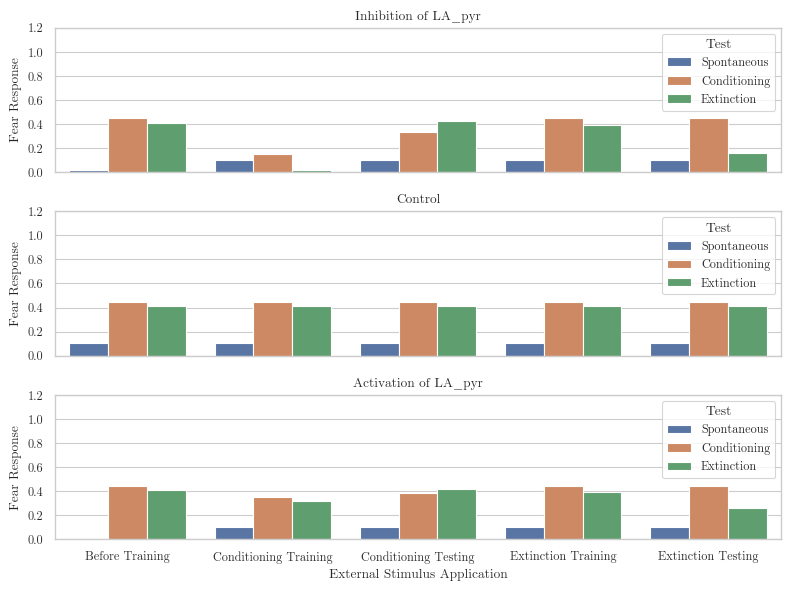

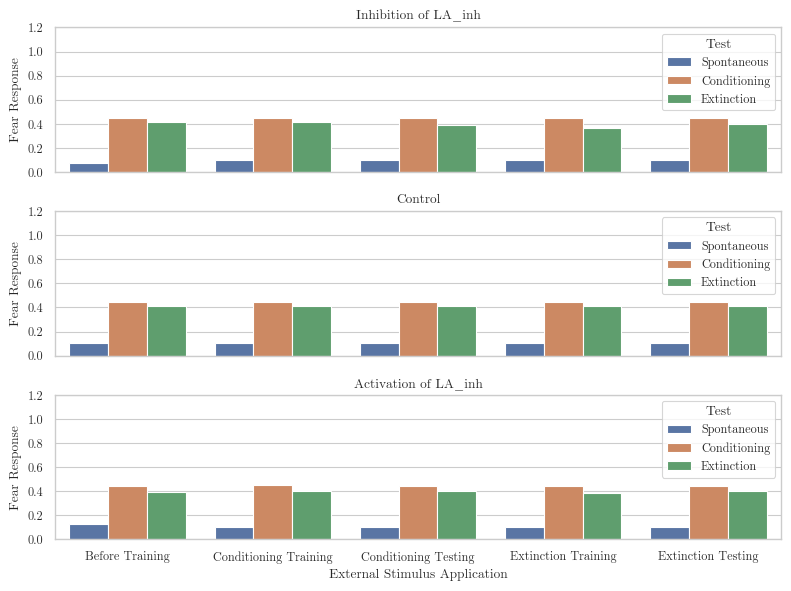

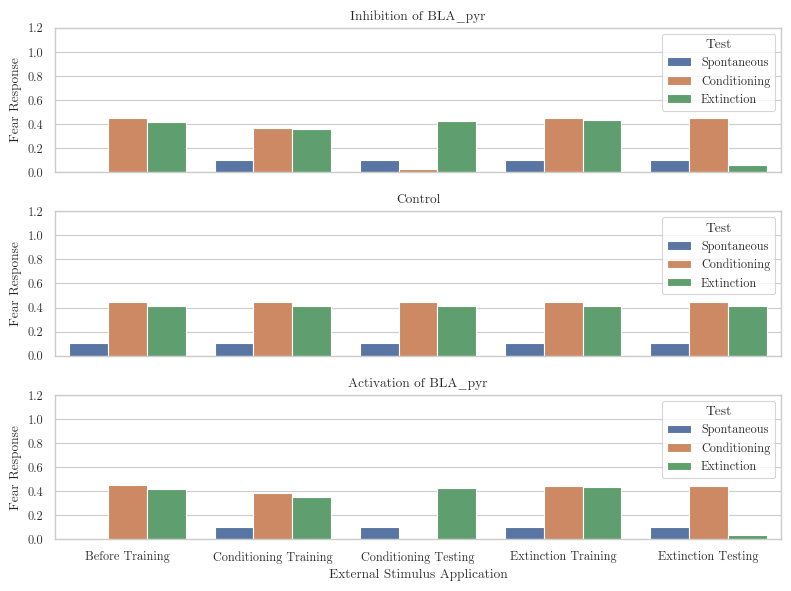

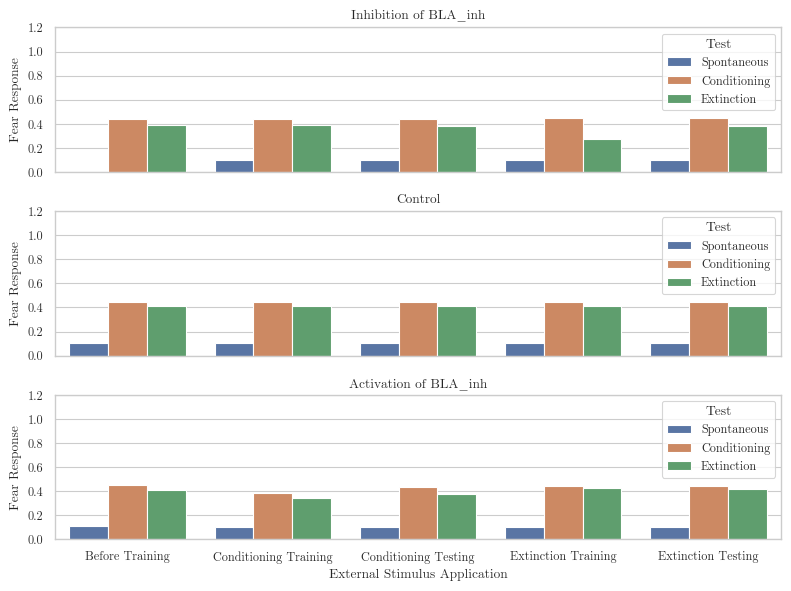

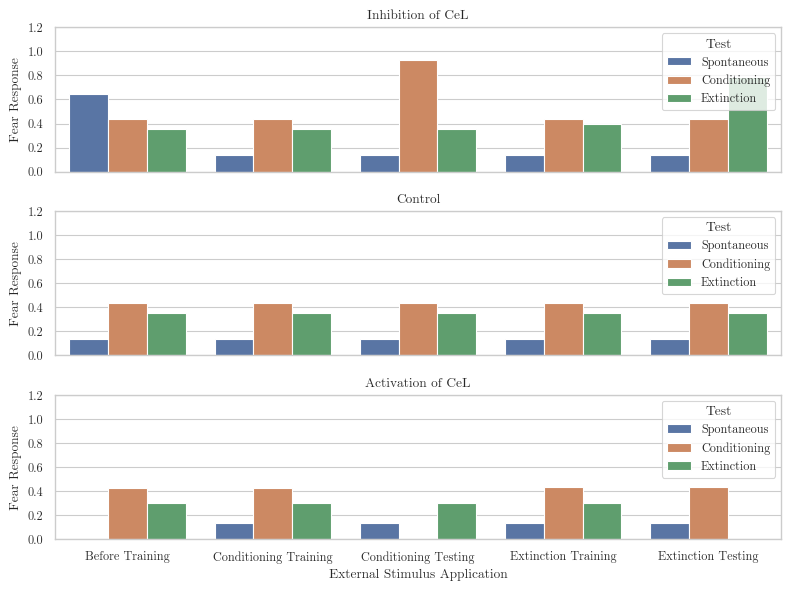

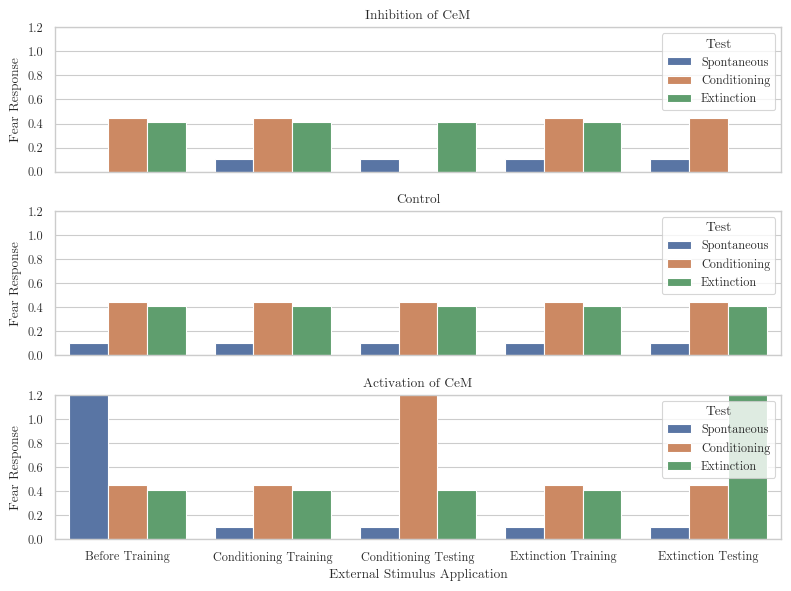

In [246]:
run_activation_inactivation(seeds=1, load=True)